In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet

In [3]:
data = pd.read_csv("data.csv")
data = data.drop(["date","country","street"],axis=1)

- Dropping the "Date", "Country" and "Street" column as they don't add any important useful information to the model building. 

In [4]:
X = data.drop("price", axis=1)
y = pd.DataFrame(data["price"])

In [5]:
categorical = X.dtypes == object
X = X.drop(y[y.price <= 0].index)
y = y.drop(y[y.price <= 0].index)

- Waterfront: A dummy variable for whether the apartment was overlooking the waterfront or not
- View: An index from 0 to 4 of how good the view of the property was
- Condition: An index from 1 to 5 on the condition of the apartment


The above variables appear to be be nominal. Here, we consider those as continuous.

In [6]:
features = list(X.columns)

In [7]:
categorical_columns = [i for i,v in categorical.items() if v]
continuous_columns = [i for i,v in categorical.items() if not v]

categorical_columns_index = [i for i,v in enumerate(features) if(v in categorical_columns)]
continuous_columns_index = [i for i,v in enumerate(features) if(v in continuous_columns)]

In [8]:
print("- Following is the list of continuous features:")
print(continuous_columns)
print()
print("- Following is the list of categorical features:")
print(categorical_columns)

- Following is the list of continuous features:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

- Following is the list of categorical features:
['city', 'statezip']


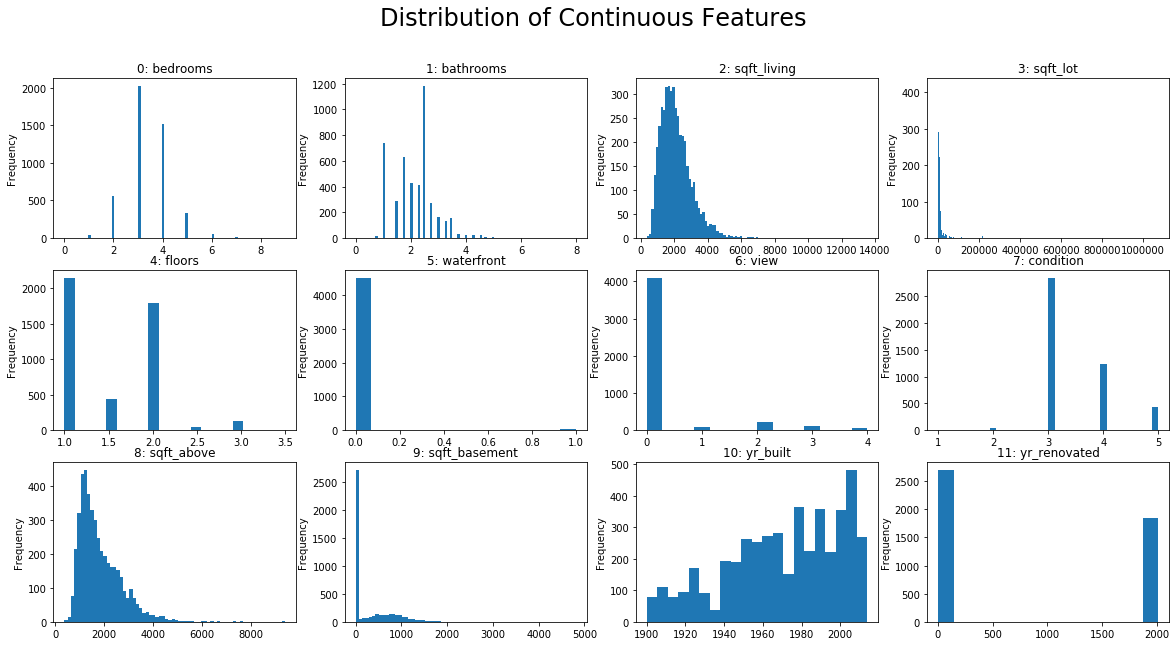

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    ax.hist(X.iloc[:,i],bins="auto")
    ax.set_title("{}: {}".format(i, continuous_columns[i]))
    ax.set_ylabel("Frequency")
fig.suptitle("Distribution of Continuous Features", fontsize=24)
plt.show()

- From the above plots it can be seen that the year renovated is having a lot of values at 0. Similar is the case for Squarefoot_basement and squarefoot lot. Thus, the 0 value seems to represent the missing values in the Dataframe and they need to be handelled.
- Also, the above plots show the nominal distributions in the case of waterdront, view, condition.


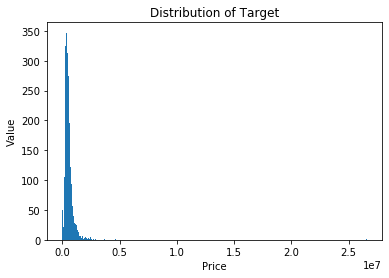

In [10]:
plt.hist(data["price"], bins="auto")
plt.xlabel("Price")
plt.ylabel("Value")
plt.title("Distribution of Target")
plt.show()

- The above plot shows that the dependent variable is sked a lot towards right side. The log transformation can be used to make it centered and have a uniformly distributed space.

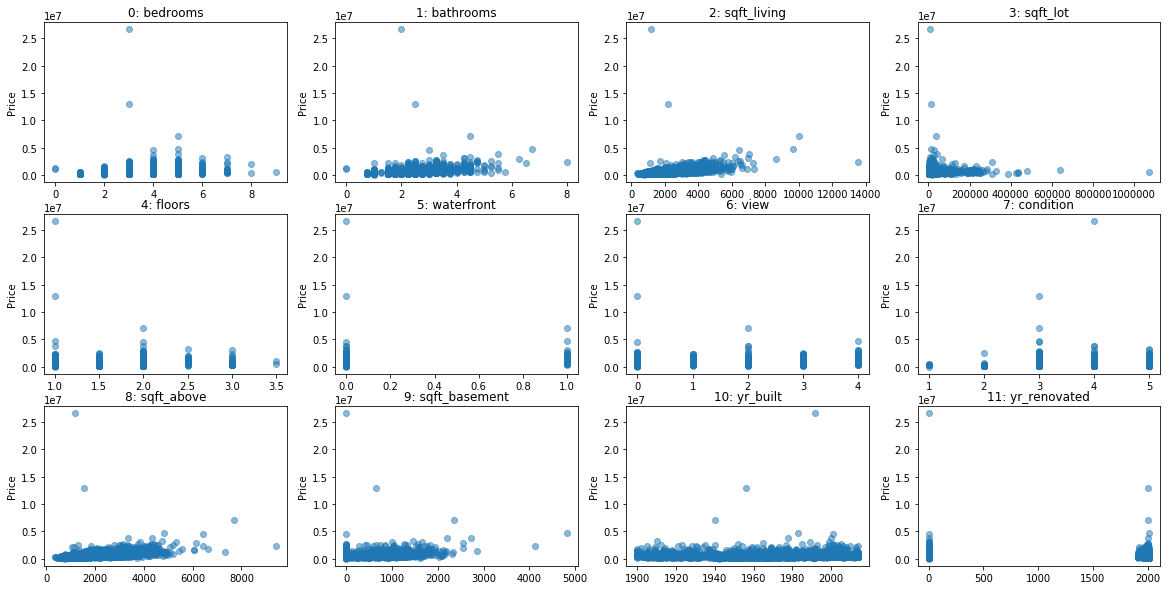

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X.iloc[:,i], y, 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, continuous_columns[i]))
    ax.set_ylabel("Price")
plt.show()

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
preprocess = make_column_transformer((TargetEncoder(), categorical_columns_index),(SimpleImputer(missing_values=0, strategy="median"), continuous_columns_index))

In [14]:
pipe1 = Pipeline([('preprocess', preprocess),
                 ('regressor', LinearRegression())])
pipe2 = Pipeline([('preprocess', preprocess),
                 ('regressor', Ridge())])
pipe3 = Pipeline([('preprocess', preprocess),
                 ('regressor', Lasso())])
pipe4 = Pipeline([('preprocess', preprocess),
                 ('regressor', ElasticNet())])

pipes=[pipe1,pipe2,pipe3,pipe4]
model_names=["Linear Regression","Ridge Regression","Lasso Regression","Elastic Net"]
scores=[]

for i in pipes:
    score = cross_val_score(i, X_train_val, y_train_val, cv=5)
    scores.append(np.mean(score))

for i in range(len(model_names)):
    print("The validation score for " + model_names[i] +" is " + str(scores[i]))

The validation score for Linear Regression is 0.5556733214589125
The validation score for Ridge Regression is 0.5556827318391002
The validation score for Lasso Regression is 0.5556743727451792
The validation score for Elastic Net is 0.5480590225577192


In [15]:
scaling = make_column_transformer((StandardScaler(), continuous_columns_index),remainder = "passthrough")
pipe1 = Pipeline([('preprocess', preprocess),
                  ('Scaler',scaling),
                 ('regressor', LinearRegression())])
pipe2 = Pipeline([('preprocess', preprocess),
                  ('Scaler',scaling),                                    
                 ('regressor', Ridge())])
pipe3 = Pipeline([('preprocess', preprocess),
                  ('Scaler',scaling),
                 ('regressor', Lasso())])
pipe4 = Pipeline([('preprocess', preprocess),
                  ('Scaler',scaling),
                 ('regressor', ElasticNet())])

pipes=[pipe1,pipe2,pipe3,pipe4]
model_names=["Linear Regression","Ridge Regression","Lasso Regression","Elastic Net"]
scores=[]

for i in pipes:
    score = cross_val_score(i, X_train_val, y_train_val, cv=5)
    scores.append(np.mean(score))

for i in range(len(model_names)):
    print("The validation score for " + model_names[i] +" is " + str(scores[i]))

The validation score for Linear Regression is 0.5556733214588785
The validation score for Ridge Regression is 0.5557223941572328
The validation score for Lasso Regression is 0.5556751755862074
The validation score for Elastic Net is 0.550711374715979


- Scaling the data with the help of pipeline as shown above does help to increase the score and imporve the performance of models(in all cases apart from the normal linear regression(OLS). The imporvement in the particualr case is not that signoificant in the case of Ridge and Lasso regression but as can be seen that in the case of Elastic Net is quite significant.

In [16]:
param_grid_ridge = [{'regressor__alpha': np.logspace(-5, 3, 15)}]
param_grid_lasso = [{'regressor__alpha': np.logspace(-5, 3, 15)}]
param_grid_elastic = [{'regressor__l1_ratio':np.logspace(-5,1,15) }]


In [17]:
grid_ridge = GridSearchCV(pipe2, param_grid_ridge)
grid_ridge.fit(X_train_val, y_train_val)
best_score = grid_ridge.score(X_test, y_test)
print("The best score for Ridge Regression is: " + str(best_score) + " with the parameter value: " + str(grid_ridge.best_params_))

The best score for Ridge Regression is: 0.6736647078680223 with the parameter value: {'regressor__alpha': 268.26957952797216}


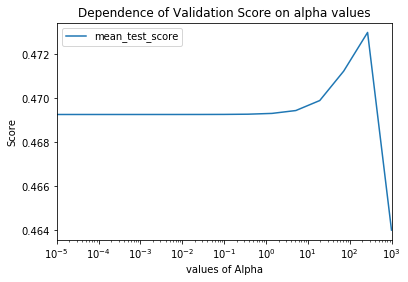

In [18]:
results = pd.DataFrame(grid_ridge.cv_results_)
results.plot('param_regressor__alpha', 'mean_test_score', ax=plt.gca())
plt.xscale("log")
plt.title("Dependence of Validation Score on alpha values")
plt.xlabel("values of Alpha")
plt.ylabel("Score")
plt.show()

In [19]:
grid_lasso = GridSearchCV(pipe3, param_grid_lasso)
grid_lasso.fit(X_train_val, y_train_val)
best_score = grid_lasso.score(X_test, y_test)
print("The best score for Lasso Regression is: " + str(best_score) + " with the parameter value: " + str(grid_lasso.best_params_))

The best score for Lasso Regression is: 0.6683617421816039 with the parameter value: {'regressor__alpha': 1000.0}


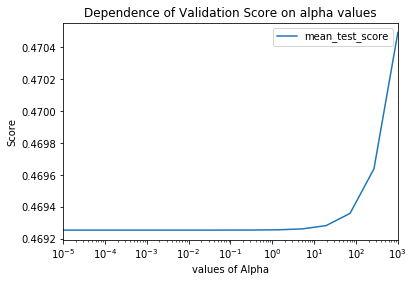

In [20]:
results = pd.DataFrame(grid_lasso.cv_results_)
results.plot('param_regressor__alpha', 'mean_test_score', ax=plt.gca())
plt.xscale("log")
plt.title("Dependence of Validation Score on alpha values")
plt.xlabel("values of Alpha")
plt.ylabel("Score")
plt.show()

In [21]:
grid_elastic = GridSearchCV(pipe4, param_grid_elastic)
grid_elastic.fit(X_train_val, y_train_val)
best_score = grid_elastic.score(X_test, y_test)
print("The best score for Elastic Net is: " + str(best_score) + " with the parameter value: " + str(grid_elastic.best_params_))

The best score for Elastic Net is: 0.6617189908401967 with the parameter value: {'regressor__l1_ratio': 0.5179474679231213}


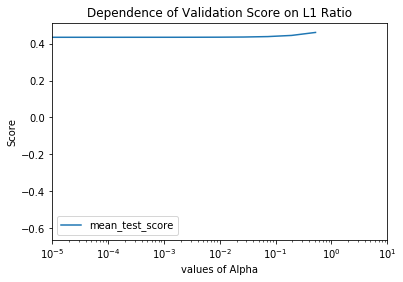

In [22]:
results = pd.DataFrame(grid_elastic.cv_results_)
results.plot('param_regressor__l1_ratio', 'mean_test_score', ax=plt.gca())
plt.xscale("log")
plt.title("Dependence of Validation Score on L1 Ratio")
plt.xlabel("values of Alpha")
plt.ylabel("Score")
plt.show()

The results in all 3 cases improve with the help of GRID Search as it helps us tune the hyperparameter (Alpha in the case of Ridge and Lasso whereas L1-Ratio in the case Elastic Net). Particularly,
- In ridge regression score improves from 0.5557223941572328 to 0.6736647078680223
- In Lasso regression score improves from 0.5556751755862074 to 0.6683617421816039 
- In Elastic Net score improves from 0.550711374715979 to 0.6617189908401967 


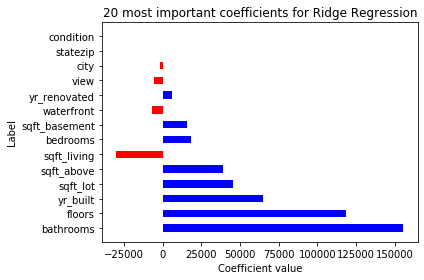

In [23]:
coefficients=grid_ridge.best_estimator_.get_params()['regressor'].coef_
features = continuous_columns.copy()
features.extend(categorical_columns)

coefficient_list = list(coefficients[0])

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for Ridge Regression")
plt.tight_layout()
plt.show()

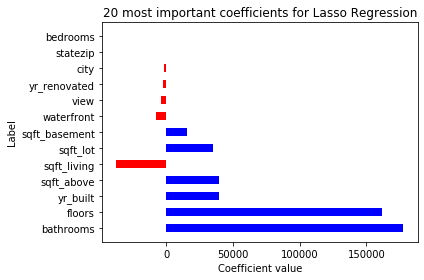

In [24]:
coefficients=grid_lasso.best_estimator_.get_params()['regressor'].coef_
features = continuous_columns.copy()
features.extend(categorical_columns)

coefficient_list = list(coefficients)

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for Lasso Regression")
plt.tight_layout()
plt.show()

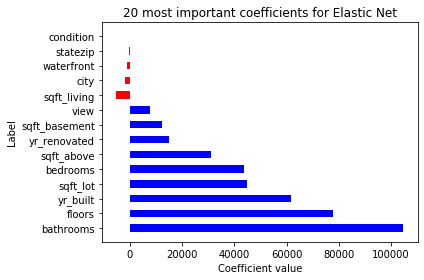

In [25]:
coefficients=grid_elastic.best_estimator_.get_params()['regressor'].coef_
features = continuous_columns.copy()
features.extend(categorical_columns)

coefficient_list = list(coefficients)

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for Elastic Net")
plt.tight_layout()
plt.show()

From the above figures it can be seen that all of the 3 models agree on the fact that "Yr_built", "bathrooms" and "floor" are the top-3 features.

They slighltly deviate from each other in the sense that Elastic rate "View" to have positive coefficient while other two claim it to be "negative". Apart from that the coefficients for other features differ in magnitude but having similar sign showing the simialr impact over the dependent variable in all the cases.